Neste notebook eu estou rodando a otimização do círculo. Dá para observar que existe algumas regiões com mínimos locais. Quanto mais fontes e medições, mais lento a convergência e menor o número de mínimos locais. Até um certo ponto isso faz diferença, depois disso, pode aumentar o número de fontes/medições que não muda. Uma vez que o DE do Scipy tem busca local, então poucas iterações são necessárias. É só pra sair de alguns mínimos. Mas é bem provável que saindo no centro/contraste-1/raio-pequeno ele chegue nos pontos de ótimo.

In [1]:
import sys
sys.path.insert(1, '../../eispy2d/library/')
import analytical as ana
import mom_cg_fft as mom
import inputdata as ipt
import draw
import configuration as cfg
import result as rst

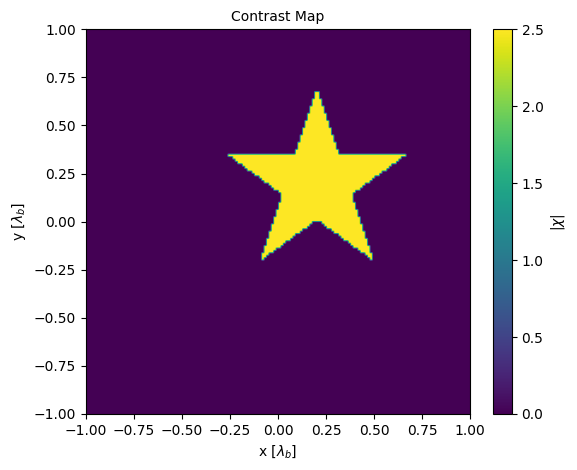

1601.94s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
1602.13s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
1602.31s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
1602.50s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
1602.68s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
1602.86s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
1603.03s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
1603.22s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [26]:
name = 'analytical'
NM = NS = 20
Ro = 4.
lambda_b = 1.
epsilon_rb = 1.
Lx = Ly = 2.
E0 = 1.
perfect_dielectric = True

config = cfg.Configuration(name=name + '.cfg', number_measurements=NM, 
                           number_sources=NS, observation_radius=Ro,
                           wavelength=lambda_b,
                           background_permittivity=epsilon_rb,
                           image_size=[Ly, Lx], magnitude=E0,
                           perfect_dielectric=perfect_dielectric)

epsilon_rd = 3.5
resolution = (160, 160)
noise = 0.
indicators = [rst.SHAPE_ERROR, rst.POSITION_ERROR]

test = ipt.InputData(name=name + '.ipt', configuration=config,
                     resolution=resolution, noise=noise, indicators=indicators)

chi = (epsilon_rd-epsilon_rb)/epsilon_rb
l = 0.5
position = [.2, .2]

test.rel_permittivity, _ = draw.star5(
    l, axis_length_x=Lx, axis_length_y=Ly, resolution=resolution,
    background_rel_permittivity=epsilon_rb, 
    object_rel_permittivity=epsilon_rd, center=position
)

test.draw(show=True)

forward = mom.MoM_CG_FFT(tolerance=1e-6, maximum_iterations=10000,
                         parallelization=True)
_ = forward.solve(test)

111.52365692757698


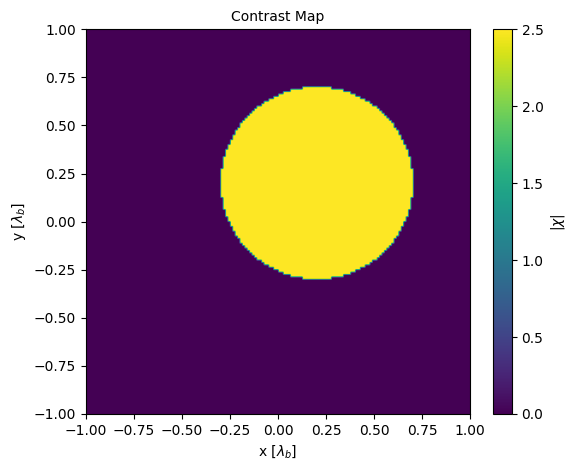

In [27]:
import numpy as np
resolution = (160, 160)
    
solver = ana.Analytical(contrast=chi, position=position, radius=l)
    
temp = ipt.InputData(name='test', configuration=test.configuration,
                         resolution=resolution)
    
_ = solver.dielectric_cylinder(temp, SAVE_INTERN_FIELD=False, 
                                   SAVE_MAP=True)
    
fx = rst.compute_rre(test.scattered_field, temp.scattered_field)

# fx = np.sum(np.abs(test.scattered_field - temp.scattered_field))/test.scattered_field.size

print(fx)
# print(test.scattered_field, temp.scattered_field)

temp.draw(show=True)

In [28]:
def func(x, data):
    position = x[:2]
    radius = x[2]
    contrast = x[3]
    resolution = (20, 20)
    
    solver = ana.Analytical(contrast=contrast, position=position,
                            radius=radius)
    
    test = ipt.InputData(name='test', configuration=data.configuration,
                         resolution=resolution)
    
    _ = solver.dielectric_cylinder(test, SAVE_INTERN_FIELD=False, 
                                   SAVE_MAP=False)
    
    return rst.compute_rre(data.scattered_field, test.scattered_field)

from scipy.optimize import minimize

initial_guess = [0., 0., .1, 1.]

bounds = [(-1., 1.), (-1., 1.), (.01, 1.), (.1, 10.)]

method = 'L-BFGS-B' # ['Nelder-Mead', 'Powell', 'CG', 'BFGS', 'L-BFGS-B', 'TNC', 'COBYLA', 'SLSQP']

solution = minimize(func, initial_guess, args=(test,), bounds=bounds,
                    method=method, options={'ftol':1e-8, 'disp':False})

print(solution)
    

      fun: 27.27367516705725
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-4.90274488e-05,  7.95807864e-05, -1.58308922e-03, -8.49098574e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 175
      nit: 21
     njev: 35
   status: 0
  success: True
        x: array([0.1964259 , 0.20555054, 0.31206659, 2.41262389])


In [23]:
import numpy as np

method = 'L-BFGS-B' 

for _ in range(5):
    initial_guess = [bounds[n][0] + (bounds[n][1] - bounds[n][0]) * np.random.rand() for n in range(4)]
    solution = minimize(func, initial_guess, args=(test,), bounds=bounds,
                    method=method)

    print(solution.x, solution.message)

[0.19891976 0.20083701 0.03543919 8.01474914] CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
[-1.         -1.          0.19878774 10.        ] CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
[-0.84258533 -0.5504449   0.7598079   8.51513783] CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
[0.19847506 0.19898709 0.29875222 0.46238621] CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
[0.19847523 0.19898679 0.2987517  0.46238712] CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH


In [25]:
from scipy.optimize import differential_evolution
differential_evolution(func, bounds, args=(test, ), strategy='best1bin', 
                       maxiter=5, popsize=40, tol=0.01, mutation=(0.5, 1), 
                       recombination=0.7, seed=None, callback=None, disp=True, 
                       polish=True, init='latinhypercube', atol=0, 
                       updating='immediate', workers=-1, constraints=(), 
                       x0=None, integrality=None, vectorized=False)

differential_evolution step 1: f(x)= 51.2844
differential_evolution step 2: f(x)= 51.2844
differential_evolution step 3: f(x)= 44.5436
differential_evolution step 4: f(x)= 35.5265
differential_evolution step 5: f(x)= 35.5265


     fun: 13.790245055570828
     jac: array([-4.97379915e-06, -3.01980663e-06, -9.59232694e-06,  1.17239551e-05])
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 1050
     nit: 5
 success: False
       x: array([0.19847508, 0.19898711, 0.29875226, 0.46238616])